<a href="https://colab.research.google.com/github/jpsicilia/spotify_analysis/blob/main/spotify_analisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

importar librerias a utilizar

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (10, 6)




cargar el data set

In [99]:
df = pd.read_csv('songs.csv')
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,Britney Spears,Oops!...I Did It Again,211160,False,2000,77,0.751,0.834,1,-5.444,0,0.0437,0.3000,0.000018,0.3550,0.894,95.053,pop
1,blink-182,All The Small Things,167066,False,1999,79,0.434,0.897,0,-4.918,1,0.0488,0.0103,0.000000,0.6120,0.684,148.726,"rock, pop"
2,Faith Hill,Breathe,250546,False,1999,66,0.529,0.496,7,-9.007,1,0.0290,0.1730,0.000000,0.2510,0.278,136.859,"pop, country"
3,Bon Jovi,It's My Life,224493,False,2000,78,0.551,0.913,0,-4.063,0,0.0466,0.0263,0.000013,0.3470,0.544,119.992,"rock, metal"
4,*NSYNC,Bye Bye Bye,200560,False,2000,65,0.614,0.928,8,-4.806,0,0.0516,0.0408,0.001040,0.0845,0.879,172.656,pop


In [100]:
df.info()
df.describe(include='all')
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist            2000 non-null   object 
 1   song              2000 non-null   object 
 2   duration_ms       2000 non-null   int64  
 3   explicit          2000 non-null   bool   
 4   year              2000 non-null   int64  
 5   popularity        2000 non-null   int64  
 6   danceability      2000 non-null   float64
 7   energy            2000 non-null   float64
 8   key               2000 non-null   int64  
 9   loudness          2000 non-null   float64
 10  mode              2000 non-null   int64  
 11  speechiness       2000 non-null   float64
 12  acousticness      2000 non-null   float64
 13  instrumentalness  2000 non-null   float64
 14  liveness          2000 non-null   float64
 15  valence           2000 non-null   float64
 16  tempo             2000 non-null   float64


,0
artist,0
song,0
duration_ms,0
explicit,0
year,0
popularity,0
danceability,0
energy,0
key,0
loudness,0


eliminar duplicados

In [101]:
# Verificar duplicados exactos
print("Duplicados exactos:", df.duplicated().sum())

# Eliminarlos
df = df.drop_duplicates()

# Ahora revisar duplicados en canciones con mismo artista
print("Duplicados artista + canción:", df.duplicated(subset=["artist", "song"]).sum())

# Nos quedamos con la más popular
df = df.sort_values(by="popularity", ascending=False).drop_duplicates(subset=["artist", "song"], keep="first")

# Resetear el índice
df = df.reset_index(drop=True)


Duplicados exactos: 59
Duplicados artista + canción: 15


In [102]:
# Arreglar géneros vacíos
df['genre'] = df['genre'].replace('set()', 'desconocido')

# Ver outliers en duración
df['duration_ms'].describe()


,duration_ms
count,1926.000000
mean,228642.718588
std,39297.197196
min,113000.000000
25%,203506.000000
50%,223259.500000
75%,248036.000000
max,484146.000000


In [103]:
df['genre_clean'] = (
    df['genre']
    .str.split(',')  # 1. Divide los géneros separados por comas en listas.
    .apply(lambda x: ', '.join(  # 2. Para cada lista:
        sorted([i.strip().lower() for i in x])  # 3. a) Limpia espacios, b) convierte a minúsculas, c) ordena.
    ))
)

### ¿Qué artistas generan más “engagement” (popularidad ponderada por cantidad de canciones)?

Este análisis busca identificar a los artistas que no solo tienen canciones populares, sino que además mantienen esa popularidad de forma consistente a lo largo de múltiples temas.  
Para ello, usamos una métrica que pondera la popularidad media por la desviación estándar y la ajusta por la cantidad de canciones (`pop_ponderada = mean / std * log(n)`).  
Esto permite **penalizar artistas con pocas canciones** (y un solo éxito viral) y **valorar más a quienes sostienen un alto engagement con volumen**.

La métrica resultante destaca a artistas con trayectoria sólida y consistencia en su rendimiento musical.


Graficar artistas con mas engagement


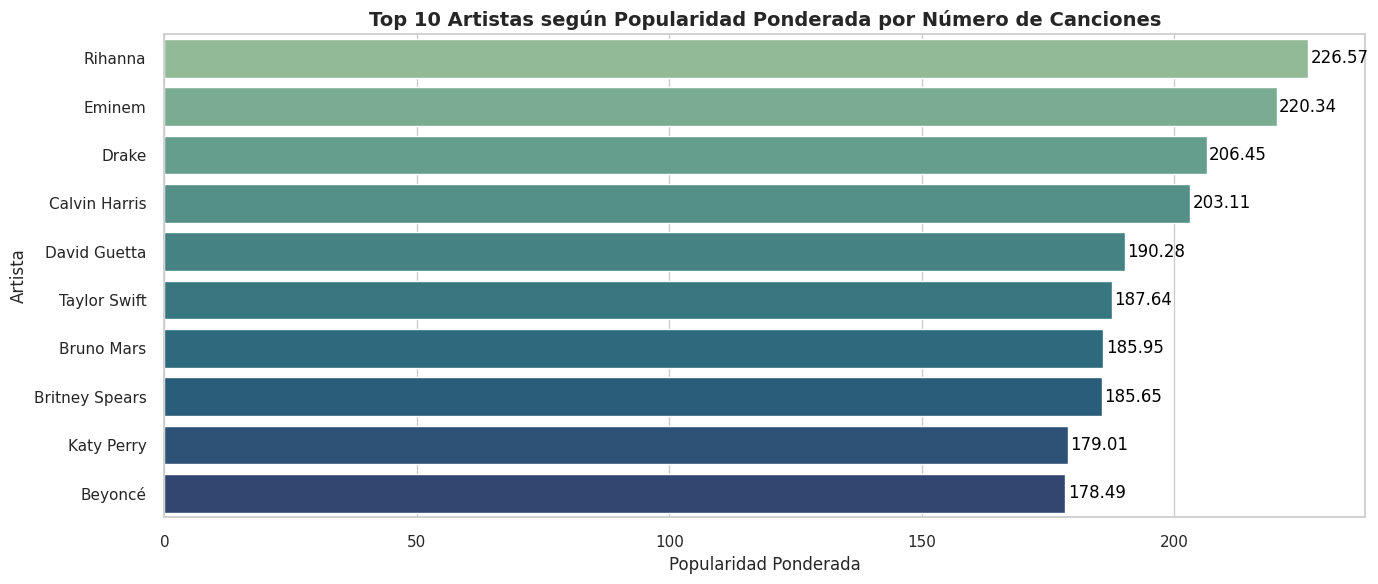

In [104]:
# Función de score ponderado
def score_ponderado(series):
    n = len(series)
    mean_pop = series.mean()
    peso = np.log(n)
    return mean_pop * peso

# Calcular el score ponderado
top_artists = df.groupby("artist")["popularity"].agg(score_ponderado)
top_artists = top_artists.sort_values(ascending=False).head(10)

# Preparar DataFrame para seaborn
df_plot = pd.DataFrame({
    'Artista': top_artists.index,
    'Score': top_artists.values
})

plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

# Graficar sin warnings
ax = sns.barplot(
    data=df_plot,
    x="Score",
    y="Artista",
    hue="Artista",
    palette="crest",

)

# Títulos y etiquetas
ax.set_title(
    "Top 10 Artistas según Popularidad Ponderada por Número de Canciones",
    fontsize=14, weight='bold'
)
ax.set_xlabel(
    "Popularidad Ponderada",
    fontsize=12
)
ax.set_ylabel("Artista", fontsize=12)

# Añadir etiquetas dentro o al final de las barras
for i, (score, artista) in enumerate(zip(df_plot['Score'], df_plot['Artista'])):
    ax.text(score + 0.5, i, f"{score:.2f}", color='black', va='center')

plt.tight_layout()
plt.show()

Géneros “premium”: popularidad vs volumen

In [105]:
# Agrupar por combinaciones de géneros
genero_stats = (
    df.groupby('genre_clean')['popularity']
      .agg(['count', 'mean'])
      .rename(columns={'count': 'num_canciones', 'mean': 'popularidad_media'})
      .reset_index()
)

# Calcular popularidad ponderada (por cantidad de canciones)
genero_stats['popularidad_ponderada'] = genero_stats['popularidad_media'] * np.log1p(genero_stats['num_canciones'])

# Ordenar para ver los más "fuertes"
genero_stats = genero_stats.sort_values(by='popularidad_ponderada', ascending=False)

In [106]:
genero_stats.head(10)

,genre_clean,num_canciones,popularidad_media,popularidad_ponderada
34,"hip hop, pop",265,64.086792,357.828369
44,pop,411,59.128954,356.016811
35,"hip hop, pop, r&b",234,59.512821,324.915333
31,hip hop,120,64.241667,308.089578
45,"pop, r&b",170,57.911765,297.762810
15,"dance/electronic, pop",213,53.741784,288.377124
50,rock,57,66.754386,271.052380
46,"pop, rock",65,62.676923,262.594668
12,"dance/electronic, hip hop, pop",75,59.546667,257.880735
43,"metal, rock",36,70.527778,254.670016


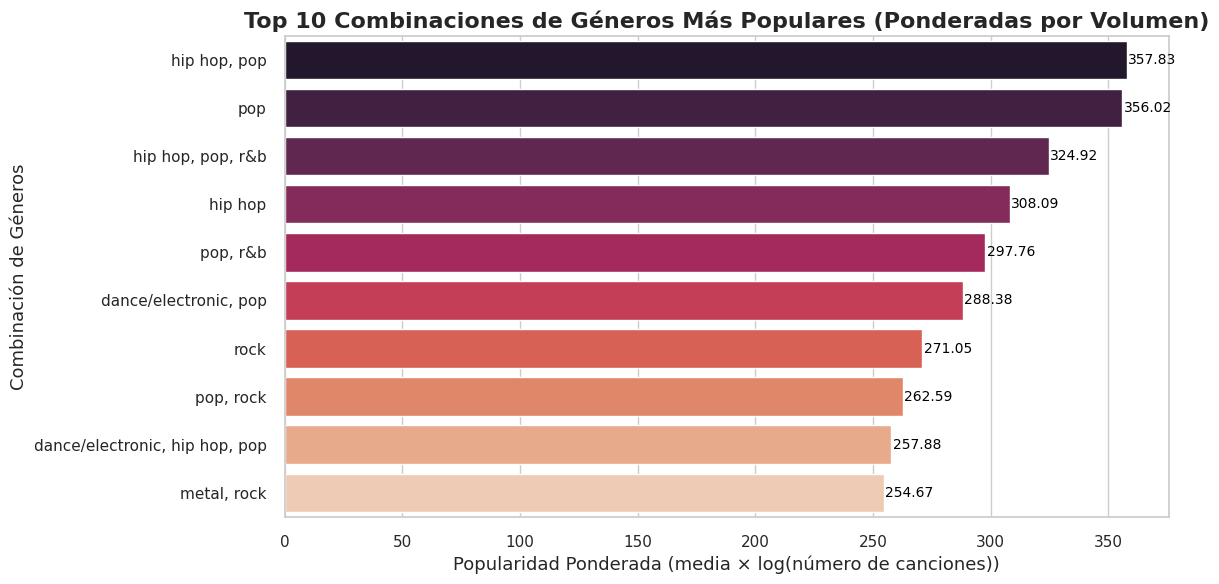

In [107]:
# Preparamos el top 10
top10 = genero_stats.sort_values(by="popularidad_ponderada", ascending=False).head(10)

# Creamos un DataFrame para seaborn (opcional, pero da orden)
df_top10 = pd.DataFrame({
    'Género': top10['genre_clean'],
    'Popularidad_Ponderada': top10['popularidad_ponderada']
})

# Plot
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")

# Graficamos
ax = sns.barplot(
    data=df_top10,
    x='Popularidad_Ponderada',
    y='Género',
    hue='Género',   # <- Para evitar el warning de seaborn
    palette='rocket',
    dodge=False,
    legend=False    # <- Quitamos la leyenda, ya está en el eje Y
)

# Títulos y etiquetas
ax.set_title(
    "Top 10 Combinaciones de Géneros Más Populares (Ponderadas por Volumen)",
    fontsize=16, weight='bold'
)
ax.set_xlabel(
    "Popularidad Ponderada (media × log(número de canciones))",
    fontsize=13
)
ax.set_ylabel(
    "Combinación de Géneros",
    fontsize=13
)

# Etiquetas dentro o al final de las barras
for i, (valor, genero) in enumerate(zip(df_top10['Popularidad_Ponderada'], df_top10['Género'])):
    ax.text(valor + 0.5, i, f"{valor:.2f}", color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()


Explícitas vs. no explícitas: ¿impacto en popularidad?

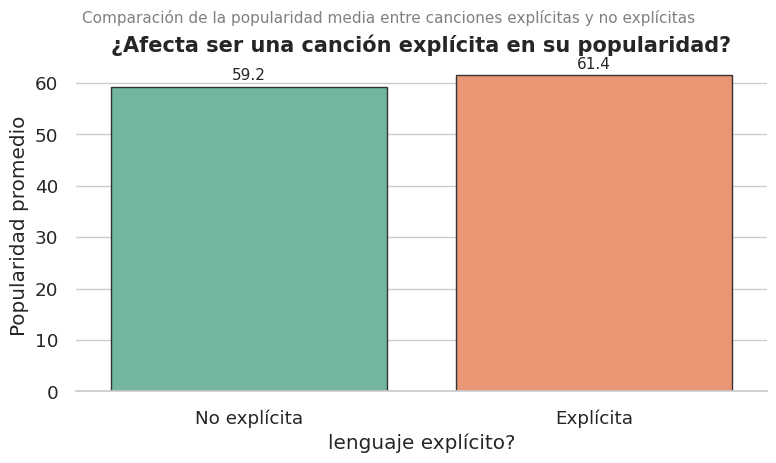

In [108]:
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8, 5))


ax = sns.barplot(
    data=groupby_explicit,
    x="explicit",
    y="avg_popularity",
    hue="explicit",
    palette="Set2",
    legend=False,
    edgecolor=".2"
)

# Etiquetas con los valores de las barras
for container in ax.containers:
    ax.bar_label(container, fmt="%.1f", label_type="edge", padding=3, fontsize=11)

# Títulos
plt.title("¿Afecta ser una canción explícita en su popularidad?", fontsize=15, weight='bold')
plt.suptitle("Comparación de la popularidad media entre canciones explícitas y no explícitas", fontsize=11, y=0.93, color='gray')

# Ejes
plt.xlabel("lenguaje explícito?")
plt.ylabel("Popularidad promedio")
plt.xticks([0, 1], ["No explícita", "Explícita"])

sns.despine(left=True)
plt.tight_layout()
plt.show()


Duración óptima: ¿canciones cortas o largas son más vistas?

In [109]:
df["min_time"] = (df["duration_ms"] / (1000 * 60)).round(2)
bins=[0,2.5,3.5,4.5,df["min_time"].max()]
labels=["<2.5 min","2.5–3.5 min","3.5–4.5 min",">4.5 min"]
df["duration_bucket"]=pd.cut(df["min_time"],bins=bins,labels=labels)
df["duration_bucket"].value_counts()


,count
duration_bucket,
3.5–4.5 min,1050
2.5–3.5 min,609
>4.5 min,249
<2.5 min,18


<ipython-input-110-58646fec172d>:8: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




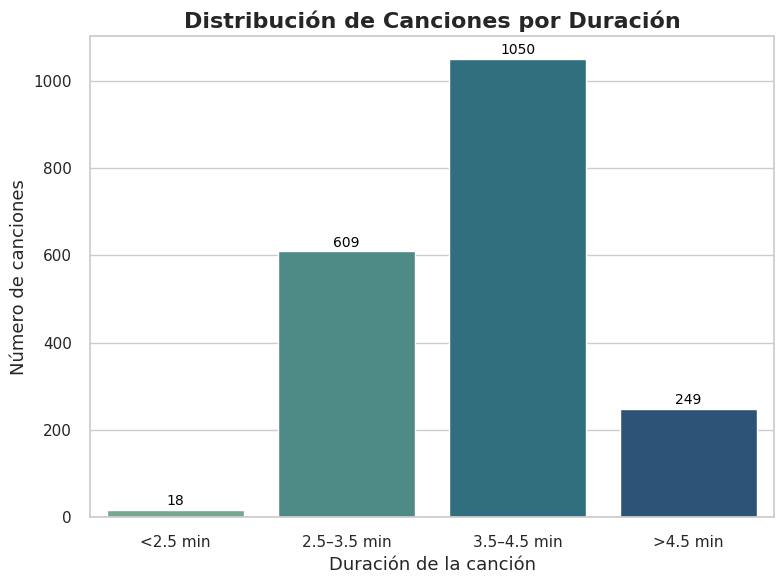

In [110]:
# Contamos cuántas canciones hay por cada rango de duración
duration_counts = df["duration_bucket"].value_counts().sort_index()

# Plot
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")

ax = sns.barplot(
    x=duration_counts.index,
    y=duration_counts.values,
    palette="crest"
)

# Títulos y etiquetas
ax.set_title(
    "Distribución de Canciones por Duración",
    fontsize=16, weight='bold'
)
ax.set_xlabel("Duración de la canción", fontsize=13)
ax.set_ylabel("Número de canciones", fontsize=13)

# Agregar los números encima de las barras
for i, v in enumerate(duration_counts.values):
    ax.text(i, v + max(duration_counts.values)*0.01, str(v), color='black', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


Popularidad por decada


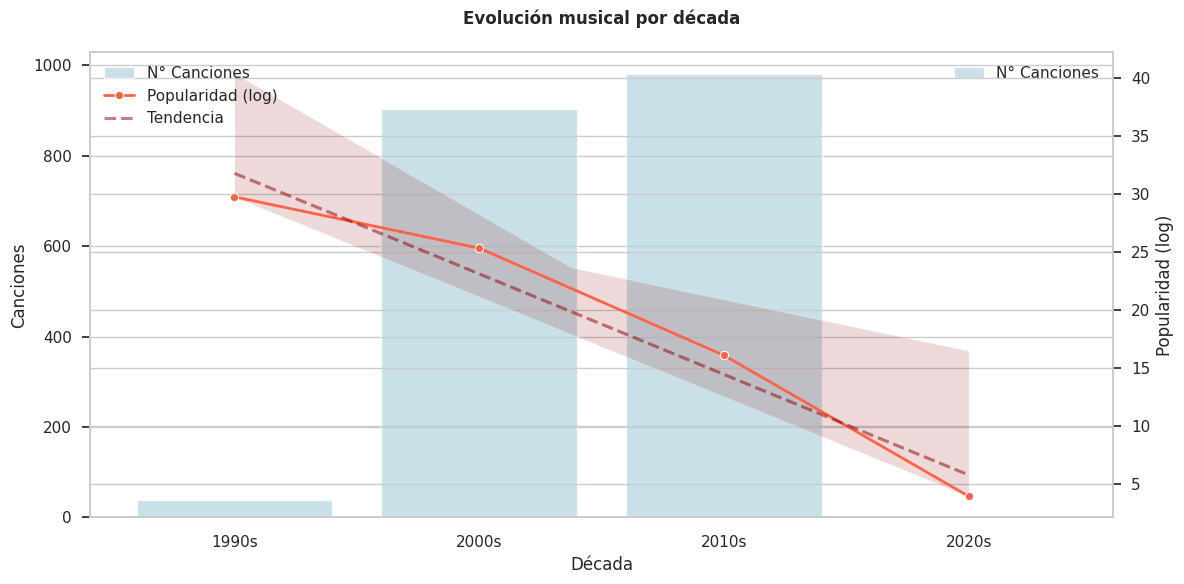

In [111]:

# 1. Preparar datos
df_decadas = groupby_decade.reset_index()
df_decadas['década'] = df_decadas['decade'].astype(str) + 's'

# 2. Crear figura
plt.figure(figsize=(12, 6))

# 3. Gráfico de barras (canciones)
ax = sns.barplot(
    data=df_decadas,
    x='década',
    y='song_count',
    color='lightblue',
    alpha=0.7,
    label='N° Canciones'
)

# 4. Gráfico de línea (popularidad)
ax2 = ax.twinx()
line = sns.lineplot(
    data=df_decadas,
    x='década',
    y='popularidad_log',
    color='tomato',
    marker='o',
    linewidth=2,
    label='Popularidad (log)',
    ax=ax2
)

# 5. Añadir tendencia (CORRECCIÓN IMPORTANTE)
if len(df_decadas) > 2:
    # Usar valores numéricos para la regresión
    x_nums = np.arange(len(df_decadas))  # Convertir a array numérico
    sns.regplot(
        x=x_nums,
        y=df_decadas['popularidad_log'],
        scatter=False,
        color='darkred',
        line_kws={'linestyle': '--', 'alpha': 0.5},
        ax=ax2,
        label='Tendencia'
    )

# 6. Personalización
plt.title('Evolución musical por década', pad=20, fontweight='bold')
ax.set_xlabel('Década')
ax.set_ylabel('Canciones')
ax2.set_ylabel('Popularidad (log)')

# 7. Leyenda unificada
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()